In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


In [5]:

import numpy as np
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model


In [7]:
#### Metrics ####


smooth = 1e-15

def dice_coef(y_true, y_pred, num_classes = 3):
    dice = 0
    for i in range(num_classes):
        y_true_i = tf.keras.layers.Flatten()(y_true[:, :, :, i])
        y_pred_i = tf.keras.layers.Flatten()(y_pred[:, :, :, i])
        intersection = tf.reduce_sum(y_true_i * y_pred_i)
        dice += (2. * intersection + smooth) / (tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i) + smooth)
    return dice / num_classes

def dice_loss(y_true, y_pred, num_classes = 3):
    return 1.0 - dice_coef(y_true, y_pred, num_classes)






def calculate_iou(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true > threshold, dtype=tf.bool)
    y_pred = tf.cast(y_pred > threshold, dtype=tf.bool)
    
    # Intersection of Union
    intersection = tf.logical_and(y_true, y_pred)
    union = tf.logical_or(y_true, y_pred)
    iou_score = tf.reduce_sum(tf.cast(intersection, tf.float32)) / tf.reduce_sum(tf.cast(union, tf.float32))
    return iou_score




In [11]:


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [12]:


model_path = 'Models\\'
csv_path = "D:\\My_Projects\\Hackton\\csv\\test.csv"
train_images_path = "D:\\My_Projects\\Hackton\\build_ramesh\\mixed_datatset\\mixed_images\\*.tif"


In [13]:
train_image_files = glob( train_images_path)


global num_classes
global image_h
global image_w

num_classes = 3
image_h = 512
image_w = 512
input_shape = (image_h, image_w, num_classes)



In [14]:
def read_image_mask(x, y):
    """ Image """
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (image_h, image_w))
    x = x/255.0
    x = x.astype(np.float32)

    """ Mask """
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (image_h, image_w))
    y = y.astype(np.int32)

    return x, y


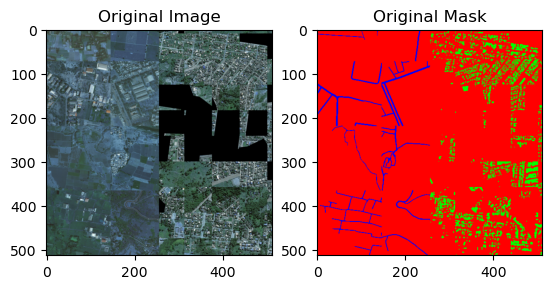

In [15]:


input_array = []

mask_array = []


for ind, image_file in enumerate(train_image_files[:100]):


    mask_file = image_file.replace('mixed_images', 'mixed_masks').replace('mixed_image', 'mixed_mask')


    image, mask = read_image_mask(image_file, mask_file)

    num_classes = 3
    image_h = 512
    image_w = 512

    ## one hot encoding ##
    mask = tf.one_hot(mask, num_classes)
    image = tf.convert_to_tensor(image)
    image.set_shape([image_h, image_w, 3])
    mask.set_shape([image_h, image_w, num_classes])

    input_array.append(image)
    mask_array.append(mask)


plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1,2,2)

plt.imshow(mask)
plt.title('Original Mask')
plt.show()

In [16]:
val_ = 0.2

val_len = int(len(input_array) * val_)

X_train = tf.convert_to_tensor(input_array[val_len:])
y_train = tf.convert_to_tensor(mask_array[val_len:])

X_val = tf.convert_to_tensor(input_array[:val_len])
y_val = tf.convert_to_tensor(mask_array[:val_len])


training_data = (X_train, y_train)
valid_data = (X_val, y_val)


callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path, append=True),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


lr = 1e-4 ## 0.0001
opt = tf.keras.optimizers.Adam(lr)
metrics = [dice_coef, calculate_iou]

model = build_unet(input_shape, num_classes)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics = metrics
)


In [17]:




history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=1,
    steps_per_epoch=len(X_train)
    
)

Epoch 1/60
52/52 [==============================] - 49s 377ms/step - loss: 1.0835 - dice_coef: 0.2571 - calculate_iou: 0.3028 - val_loss: 0.9195 - val_dice_coef: 0.2563 - val_calculate_iou: 0.0000e+00
Epoch 2/60
52/52 [==============================] - 19s 363ms/step - loss: 0.4980 - dice_coef: 0.3357 - calculate_iou: 0.7701 - val_loss: 0.7048 - val_dice_coef: 0.2912 - val_calculate_iou: 0.7555
Epoch 3/60
52/52 [==============================] - 19s 365ms/step - loss: 0.4136 - dice_coef: 0.3538 - calculate_iou: 0.8152 - val_loss: 0.5949 - val_dice_coef: 0.3108 - val_calculate_iou: 0.7725
Epoch 4/60
52/52 [==============================] - 19s 365ms/step - loss: 0.3758 - dice_coef: 0.3690 - calculate_iou: 0.8230 - val_loss: 0.5253 - val_dice_coef: 0.3251 - val_calculate_iou: 0.7737
Epoch 5/60
52/52 [==============================] - 19s 367ms/step - loss: 0.3499 - dice_coef: 0.3816 - calculate_iou: 0.8289 - val_loss: 0.4759 - val_dice_coef: 0.3350 - val_calculate_iou: 0.7737
Epoch 6/60


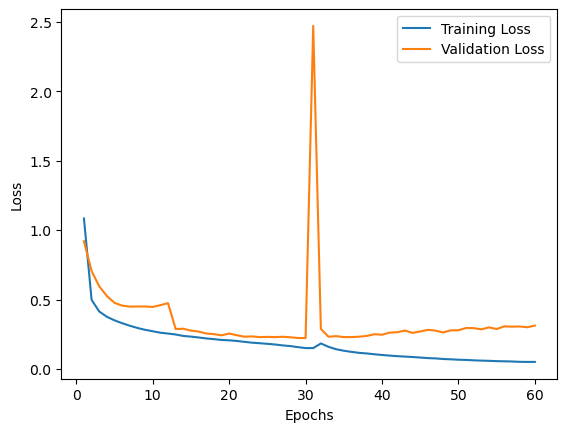

In [18]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs = range(1, len(training_loss) + 1)

# Plot the loss curves
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict Train Data

1/1 [==============================] - 0s 464ms/step


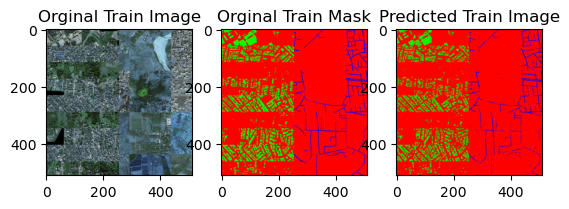

In [19]:
random = 2

resized_image = tf.image.resize(X_train[random], (512, 512))

# Add batch dimension
resized_image_train = tf.expand_dims(resized_image, axis=0)


predict_train = model.predict(resized_image_train)
# predict[predict <=1.5]

plt.subplot(1,3,1)
plt.imshow(resized_image)
plt.title('Orginal Train Image')


plt.subplot(1,3,2)
plt.imshow(y_train[random])
plt.title('Orginal Train Mask')


plt.subplot(1,3,3)
plt.imshow(predict_train.squeeze())
plt.title('Predicted Train Image')

plt.show()

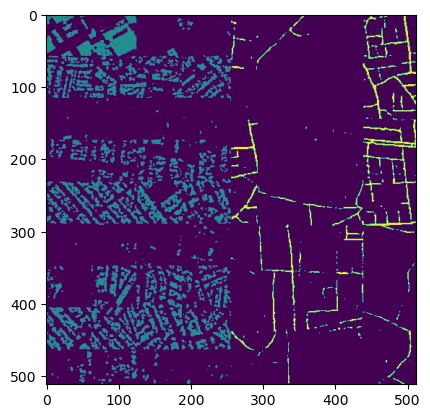

In [20]:
plt.imshow(np.argmax(predict_train, axis=-1).squeeze())

# Validation Data

1/1 [==============================] - 0s 48ms/step


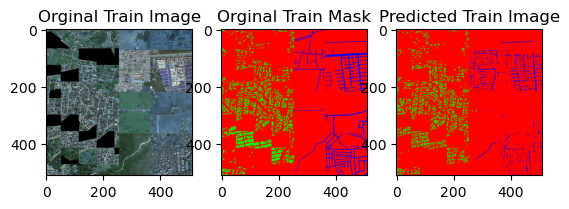

In [21]:
random = 4

resized_image = tf.image.resize(X_val[random], (512, 512))

# Add batch dimension
resized_image_train = tf.expand_dims(resized_image, axis=0)


predict_train = model.predict(resized_image_train)
# predict[predict <=1.5]

plt.subplot(1,3,1)
plt.imshow(resized_image)
plt.title('Orginal Train Image')


plt.subplot(1,3,2)
plt.imshow(y_val[random])
plt.title('Orginal Train Mask')


plt.subplot(1,3,3)
plt.imshow(predict_train.squeeze())
plt.title('Predicted Train Image')

plt.show()

## SKY Serve data 

In [22]:
random = 1

test_image = "D:\\My_Projects\\Hackton\\build_ramesh\\val_data\\masks\\Jind_Denali_MS_1700_2300_mask.tif"

x = cv2.imread(test_image, cv2.IMREAD_COLOR)
x = cv2.resize(x, (512, 512))
x = x/255.0
x = x.astype(np.float32)

x = tf.convert_to_tensor(x)

resized_test_image = tf.expand_dims(x, axis=0)

1/1 [==============================] - 0s 52ms/step


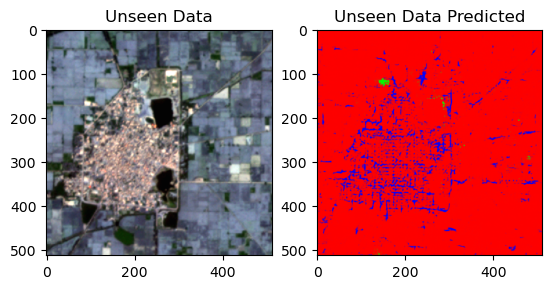

In [23]:
test_pred = model.predict(resized_test_image)

plt.subplot(1,2,1)
plt.imshow(x)
plt.title('Unseen Data')

plt.subplot(1,2,2)
plt.imshow(test_pred.squeeze())
plt.title('Unseen Data Predicted')
plt.show()

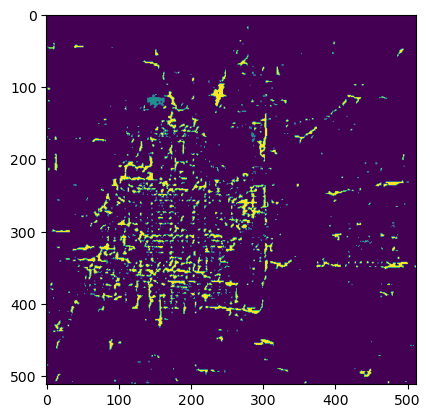

In [24]:
plt.imshow(np.argmax(test_pred, axis=-1).squeeze())

### Save Model

In [2]:


model.save(model_file)

NameError: name 'model' is not defined

In [10]:
import tf2onnx
import onnx 
import onnxruntime as ort 

model_file = 'build_ramesh/Model_512/M1.h5'

dependencies = {
    'dice_coef': dice_coef,
    'calculate_iou':calculate_iou
}
model_tmp = tf.keras.models.load_model(model_file, custom_objects=dependencies)
model_tmp.summary()

input_signature = (tf.TensorSpec((None, 512,512,3), tf.int8, name="input_2"),)  #Fill these from the model_summary() outputs
onnx_model, _ = tf2onnx.convert.from_keras(model_tmp, input_signature, opset=11) # use opset 11 
onnx.save(onnx_model, "build_ramesh/Model_512/model.onnx")

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             